# Object detection with scivision

In this notebook, we use scivision to load several object detection models from [Hugging Face](https://huggingface.co/models?pipeline_tag=object-detection&sort=downloads) and run them on compatible datasource from the scivision catalog.

The hugging face models are loaded via the hugging face object detection plugin for scivision, which is a model entry in the scivision catalog. Click the [link to the plugin repo](https://github.com/alan-turing-institute/scivision_huggingface_objectdetection) to find out which models it can be used to load. 

In [1]:
from scivision import default_catalog, load_pretrained_model, load_dataset, predplot

In [2]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == "huggingface-object-detection"].url.item()
model_repo # Why not paste the repo link into your browser and see how it looks?

AnyUrl('https://github.com/alan-turing-institute/scivision_huggingface_objectdetection', scheme='https', host='github.com', tld='com', host_type='domain', path='/alan-turing-institute/scivision_huggingface_objectdetection')

Now let's load two of the models:

In [3]:
facebook_model = load_pretrained_model(model_repo, model='facebook_detr_resnet_50')

In [4]:
yolo_model = load_pretrained_model(model_repo, model='hustvl_yolos_tiny')

We can search the scivision for compatible datasources:

In [5]:
compatible_datasources = default_catalog.compatible_datasources("huggingface-object-detection").to_dataframe()
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Koala,"(TaskEnum.object_detection, TaskEnum.classific...","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"


Let's choose the test dataset "data-003" which has includes an image of an airport.

In [6]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-003']
data_config = load_dataset(target_datasource.url.item())
print([i for i in data_config.keys()])

['test_image', 'airport']


In [7]:
airport = data_config.airport().to_dask() # The xarray.DataArray is one format accepted by the our models

/opt/anaconda3/envs/scivision/lib/python3.9/site-packages/xarray/core/dataset.py:2172: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


What does this image look like?

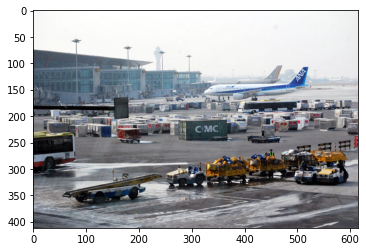

In [8]:
import matplotlib.pyplot as plt
plt.imshow(airport)

## Model predictions

Now let's use predict the objects in the airport test image we found in the scivision catalog, using the loaded object detection models. The output can be visualised with scivision's `predplot` function.

In [9]:
fb_model_objects = facebook_model.predict(airport)

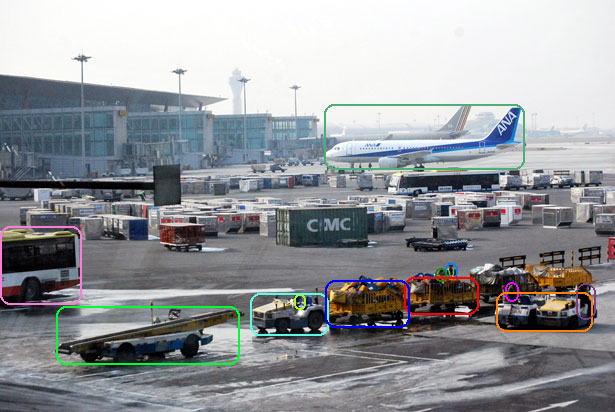

/Users/echalstrey/projects/scivision/scivision/vis/display.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  object_predictions = pd.DataFrame(predictions).drop('box', 1)


,score,label,bbox
0,0.968878,truck,0
1,0.970690,person,1
2,0.969587,truck,2
3,0.982232,person,3
4,0.978991,person,4
5,0.912243,person,5
6,0.988615,truck,6
7,0.988031,bus,7
8,0.953983,person,8
9,0.902741,truck,9


In [10]:
predplot(airport, fb_model_objects, task="object detection")

In [11]:
yolo_model_objects = yolo_model.predict(airport)

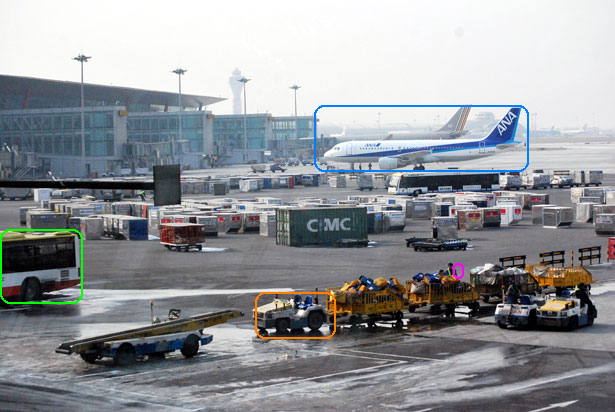

/Users/echalstrey/projects/scivision/scivision/vis/display.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  object_predictions = pd.DataFrame(predictions).drop('box', 1)


,score,label,bbox
0,0.979696,bus,0
1,0.904443,person,1
2,0.993001,airplane,2
3,0.922632,truck,3


In [12]:
predplot(airport, yolo_model_objects, task="object detection")

What does the output from the model predict look like? This format is accepted by `predplot`:

In [20]:
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
from distinctipy import distinctipy

In [21]:


# number of colours to generate
N = 12

# generate N visually distinct colours
rgb_colors = distinctipy.get_colors(N)

hex_colors = []
for color in rgb_colors:
    hex_colors.append(rgb2hex(color))

In [23]:
def get_col(s):
    return ['background-color: ' + hex_colors[s.bbox-1]]*3

In [24]:
predictions = fb_model_objects
object_predictions = pd.DataFrame(predictions).drop('box', 1)
object_predictions['bbox'] = object_predictions.index + 1
object_predictions.style.apply(get_col, axis=1)

/var/folders/kf/72snt1z56h56smb3y7c0dxpr9rwb6q/T/ipykernel_59389/981726130.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  object_predictions = pd.DataFrame(predictions).drop('box', 1)


,score,label,bbox
0,0.968878,truck,1
1,0.970690,person,2
2,0.969587,truck,3
3,0.982232,person,4
4,0.978991,person,5
5,0.912243,person,6
6,0.988615,truck,7
7,0.988031,bus,8
8,0.953983,person,9
9,0.902741,truck,10
